In [1]:
# ============================================================
# Bi-LSTM for HumAID (events_set1_combined_clean.tsv)
# - Input:  text_clean
# - Label:  class_label (10 topics)
# - Model:  Embedding -> Bi-LSTM -> Dense(10, softmax)
# - Loss:   sparse_categorical_crossentropy
# - Metric: sparse_categorical_accuracy
# ============================================================

# If needed, install packages (uncomment in a notebook)
# !pip install numpy pandas scikit-learn tensorflow matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. Reproducibility (optional but nice)
# ------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DATA_PATH = "events_set1_combined_clean.tsv"

df = pd.read_csv(DATA_PATH, sep="\t")

TEXT_COL  = "tweet_text"
LABEL_COL = "class_label"

df = df.dropna(subset=[TEXT_COL, LABEL_COL])

X_text = df[TEXT_COL].astype(str).values
y_raw  = df[LABEL_COL].astype(str).values
print("Columns:", df.columns.tolist())

Columns: ['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean']


In [4]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y_raw)   # integer labels
num_classes = len(label_encoder.classes_)
print("Number of classes:", num_classes)
print("Class mapping (id -> label):")
for i, lab in enumerate(label_encoder.classes_):
    print(f"{i}: {lab}")
print()

Number of classes: 10
Class mapping (id -> label):
0: caution_and_advice
1: displaced_people_and_evacuations
2: infrastructure_and_utility_damage
3: injured_or_dead_people
4: missing_or_found_people
5: not_humanitarian
6: other_relevant_information
7: requests_or_urgent_needs
8: rescue_volunteering_or_donation_effort
9: sympathy_and_support



In [5]:
# 4. Train / test split
# ------------------------------------------------------------
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y_int,
    test_size=0.2,
    random_state=SEED,
    stratify=y_int
)

print("Train size:", len(X_train_text))
print("Test size :", len(X_test_text), "\n")


Train size: 34727
Test size : 8682 



In [6]:
# 5. Tokenize and pad sequences
# ------------------------------------------------------------
MAX_WORDS = 20000   # max vocab size
MAX_LEN   = 40      # max tokens per tweet (can tune)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(
    X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post"
)
X_test_pad  = pad_sequences(
    X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post"
)

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
print("Vocab size used:", vocab_size)
print("Train tensor shape:", X_train_pad.shape)
print("Test tensor shape :", X_test_pad.shape, "\n")

Vocab size used: 20000
Train tensor shape: (34727, 40)
Test tensor shape : (8682, 40) 



In [7]:
# 6. Build Bi-LSTM model (as in the report)
# ------------------------------------------------------------
EMB_DIM      = 100   # embedding dimension (tunable)
LSTM_UNITS   = 128   # Bi-LSTM units (tunable)
DROPOUT_RATE = 0.5

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMB_DIM,
        input_length=MAX_LEN
    ),
    Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=False,recurrent_dropout=0.2)
    ),
    Dropout(DROPOUT_RATE),
    Dense(num_classes, activation="softmax")   # size 10, one per topic
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",     
    metrics=["sparse_categorical_accuracy"]     
)



C:\Users\jmq\anaconda3\envs\torchenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# 7. Train with early stopping
# ------------------------------------------------------------
BATCH_SIZE = 64
EPOCHS     = 15

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)



history = model.fit(
    X_train_pad,
    y_train,                      # integer labels
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/15
489/489 - 32s - 65ms/step - loss: 1.2310 - sparse_categorical_accuracy: 0.5962 - val_loss: 0.8157 - val_sparse_categorical_accuracy: 0.7354
Epoch 2/15
489/489 - 30s - 62ms/step - loss: 0.7125 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.7694 - val_sparse_categorical_accuracy: 0.7509
Epoch 3/15
489/489 - 28s - 56ms/step - loss: 0.5380 - sparse_categorical_accuracy: 0.8224 - val_loss: 0.8326 - val_sparse_categorical_accuracy: 0.7365
Epoch 4/15
489/489 - 28s - 58ms/step - loss: 0.4149 - sparse_categorical_accuracy: 0.8663 - val_loss: 0.9307 - val_sparse_categorical_accuracy: 0.7311
Epoch 5/15
489/489 - 31s - 62ms/step - loss: 0.3250 - sparse_categorical_accuracy: 0.8974 - val_loss: 1.0035 - val_sparse_categorical_accuracy: 0.7201


In [9]:
# 8. Evaluate on test set (accuracy + macro F1)
# ------------------------------------------------------------
y_prob = model.predict(X_test_pad)
y_pred_int = y_prob.argmax(axis=1)

acc = accuracy_score(y_test, y_pred_int)
macro_f1 = f1_score(y_test, y_pred_int, average="macro")

print("\n================= TEST PERFORMANCE =================")
print(f"Bi-LSTM test accuracy:  {acc:.4f}")
print(f"Bi-LSTM macro F1:       {macro_f1:.4f}\n")

print("Per-class metrics:\n")
print(classification_report(
    y_test,
    y_pred_int,
    target_names=label_encoder.classes_
))

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

================= TEST PERFORMANCE =================
Bi-LSTM test accuracy:  0.7529
Bi-LSTM macro F1:       0.6606

Per-class metrics:

                                        precision    recall  f1-score   support

                    caution_and_advice       0.69      0.59      0.64       458
      displaced_people_and_evacuations       0.83      0.90      0.86       427
     infrastructure_and_utility_damage       0.83      0.85      0.84      1209
                injured_or_dead_people       0.90      0.92      0.91       847
               missing_or_found_people       0.89      0.22      0.36        36
                      not_humanitarian       0.36      0.12      0.18       397
            other_relevant_information       0.55      0.61      0.58      1529
              requests_or_urgent_needs       0.61      0.57      0.59       330
rescue_volunteering_or_donation_effort       0.79      0.86      0.83      2433
                  sy

Embedding matrix: (20000, 100)
Selected words: 79
['hurricane', 'flood', 'wildfire', 'tsunami', 'storm', 'earthquake', 'irma', 'maria', 'harvey', 'florence', 'haiti', 'puerto', 'ecuador', 'california', 'trump', 'realdonaldtrump', 'florida', 'texas', 'puerto', 'rico', 'haiti', 'million', 'climate', 'toll', 'warn', 'warning', 'evacuate', 'evacuation', 'prepare', 'ready', 'stay', 'safe', 'need', 'food', 'water', 'shelter', 'medicine', 'medical', 'help', 'damage', 'damaged', 'destroyed', 'collapsed', 'devastated', 'victim', 'victims', 'donate', 'donation', 'donations', 'fundraiser', 'money', 'relief', 'support', 'prayer', 'prayers', 'pray', 'hope', 'thought', 'thoughts', 'safe', 'evacuate', 'evacuation', 'shelter', 'escape', 'evacu', 'kill', 'killed', 'death', 'deaths', 'injured', 'injury', 'victim', 'victims', 'dead', 'politics', 'government', 'policy', 'trump', 'realdonaldtrump']
Background tokens: 250
t-SNE input: (329, 100)


C:\Users\jmq\AppData\Local\Temp\ipykernel_39776\266382784.py:196: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jmq\anaconda3\envs\torchenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


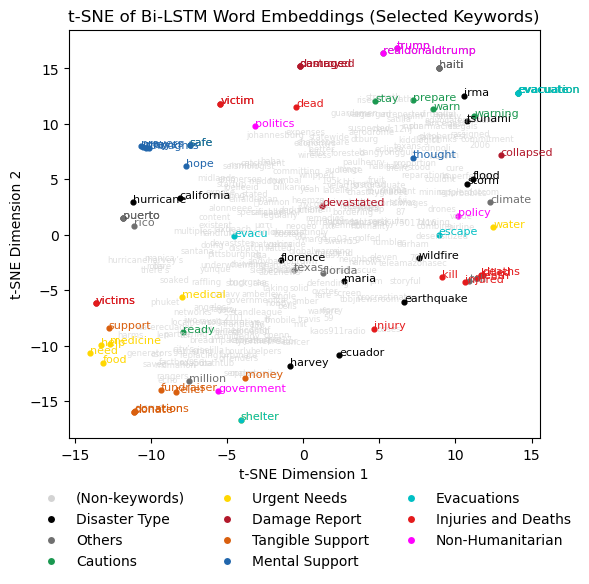

In [10]:
# Embedding matrix from the first layer
embedding_layer = model.layers[0]
embedding_matrix = embedding_layer.get_weights()[0]   # (vocab_size, EMB_DIM)
vocab_size, EMB_DIM = embedding_matrix.shape
print("Embedding matrix:", embedding_matrix.shape)

# word <-> index
word_index = tokenizer.word_index          # word -> idx (1..)
index_word = {idx: w for w, idx in word_index.items()}


# ------------------------------------------------------------
# 9. Define representative keywords per topic (edit as you like)
# ------------------------------------------------------------
topic_to_words = {
    "Disaster Type": [
        "hurricane","flood","wildfire","tsunami","storm","earthquake",
        "irma","maria","harvey","florence","haiti","nebraska","puerto","ecuador","california"
    ],
    "Others": [
        "trump","realdonaldtrump","florida","texas","nebraska","puerto","rico","haiti",
        "million","climate","toll"
    ],
    "Cautions": [
        "warn","warning","evacuate","evacuation","prepare","ready","stay","safe"
    ],
    "Urgent Needs": [
        "need","food","water","shelter","medicine","medical","help"
    ],
    "Damage Report": [
        "damage","damaged","destroyed","destruct","collapsed","devastated","victim","victims"
    ],
    "Tangible Support": [
        "donate","donation","donations","fundraiser","money","relief","support"
    ],
    "Mental Support": [
        "prayer","prayers","pray","hope","thought","thoughts","safe"
    ],
    "Evacuations": [
        "evacuate","evacuation","shelter","escape","evacu"
    ],
    "Injuries and Deaths": [
        "kill","killed","death","deaths","injured","injury","victim","victims","dead"
    ],
    "Non-Humanitarian": [
        "politics","government","policy","trump","realdonaldtrump"
    ]
}

# ------------------------------------------------------------
# 10. Collect selected keywords that actually exist in vocab
# ------------------------------------------------------------
selected_words = []
selected_topics = []

for topic, words in topic_to_words.items():
    for w in words:
        idx = word_index.get(w)
        if idx is not None and idx < vocab_size:
            selected_words.append(w)
            selected_topics.append(topic)

print("Selected words:", len(selected_words))
print(selected_words)
# ------------------------------------------------------------
# 11. Build background token list (for grey points)
# ------------------------------------------------------------
# indices 1..vocab_size-1 are real tokens
all_indices = np.arange(1, vocab_size)

selected_indices = {word_index[w] for w in selected_words if w in word_index}
background_indices = [idx for idx in all_indices if idx not in selected_indices]

# sample a subset for clarity
N_BACKGROUND = 250
if len(background_indices) > N_BACKGROUND:
    background_indices = np.random.choice(background_indices, size=N_BACKGROUND, replace=False)

print("Background tokens:", len(background_indices))


# ------------------------------------------------------------
# 12. Prepare vectors for t-SNE
# ------------------------------------------------------------
bg_vectors = embedding_matrix[background_indices]
kw_indices = [word_index[w] for w in selected_words]
kw_vectors = embedding_matrix[kw_indices]

all_vectors = np.vstack([bg_vectors, kw_vectors])
print("t-SNE input:", all_vectors.shape)

tsne = TSNE(
    n_components=2,
    perplexity=35,
    random_state=0,   # fixed for reproducibility
    init="pca",       # closer to paper-like layout
    learning_rate=200
    # no n_iter here in your sklearn version
)

coords = tsne.fit_transform(all_vectors)
coords_bg = coords[:len(bg_vectors)]
coords_kw = coords[len(bg_vectors):]

# ------------------------------------------------------------
# 14. Plot: grey background + colored keywords
# ------------------------------------------------------------
# Colors chosen to approximate the paper
topic_colors = {
    "Disaster Type":           "#000000",  # black
    "Others":                  "#707070",  # dark grey
    "Cautions":                "#1a9850",  # green
    "Urgent Needs":            "#FFD700",  # gold
    "Damage Report":           "#b2182b",  # dark red/brown
    "Tangible Support":        "#d95f0e",  # orange
    "Mental Support":          "#2166ac",  # blue
    "Evacuations":             "#00bfc4",  # cyan
    "Injuries and Deaths":     "#e41a1c",  # bright red
    "Non-Humanitarian":        "#ff00ff"   # magenta
}

plt.figure(figsize=(6,6))

# 1) grey background words
for idx, (x, y) in enumerate(coords_bg):
    w = index_word.get(background_indices[idx], "")
    if not w:
        continue
    plt.text(
        x, y, w,
        fontsize=6,
        color="#d3d3d3",   # light grey
        alpha=0.7
    )

# 2) colored topic keywords
for topic in topic_to_words.keys():
    indices = [i for i, t in enumerate(selected_topics) if t == topic]
    if not indices:
        continue
    color = topic_colors[topic]
    xs = coords_kw[indices, 0]
    ys = coords_kw[indices, 1]

    # small dots
    plt.scatter(xs, ys, s=12, c=color)

    # word labels
    for i in indices:
        plt.text(
            coords_kw[i, 0],
            coords_kw[i, 1],
            selected_words[i],
            fontsize=8,
            color=color
        )

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE of Bi-LSTM Word Embeddings (Selected Keywords)")

# Legend order to match the paper
legend_order = [
    "(Non-keywords)",
    "Disaster Type", "Others", "Cautions",
    "Urgent Needs", "Damage Report", "Tangible Support", "Mental Support",
    "Evacuations", "Injuries and Deaths", "Non-Humanitarian"
]

# Build proxy artists for legend
handles = []
labels  = []

# non-keywords
handles.append(plt.Line2D([0],[0], marker='o', color='w',
                          markerfacecolor="#d3d3d3", markersize=6))
labels.append("(Non-keywords)")

for topic in [
    "Disaster Type","Others","Cautions",
    "Urgent Needs","Damage Report","Tangible Support","Mental Support",
    "Evacuations","Injuries and Deaths","Non-Humanitarian"
]:
    handles.append(plt.Line2D([0],[0], marker='o', color='w',
                              markerfacecolor=topic_colors[topic], markersize=6))
    labels.append(topic)

plt.legend(
    handles, labels,
    bbox_to_anchor=(0.5, -0.1),
    loc="upper center",
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()
